<a href="https://colab.research.google.com/github/ussvarma/time_series_analysis/blob/main/Model_3_XGB_multi_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement:
Title - Forecast next 12 month spend based on past spend data

You need to create a system to forecast the spend of a company based on the past historical data of the last 24 months on a monthly scale.

First you need to identify the various spends a company does, you can take an example of any base company and identify the various spends a company does in a complete year, and create some fictional spend numbers of that company as training data.

After that you need to identify various features you will consider to train your model, to predict or forecast the spending company would do in the next 12 months.

You need to think through the approach you will take, the features you will identify and the algorithm you will use to achieve this. For the ML model training you can create fictional data and perform the training.

# XGBoost model for multioutput(12 month)


## Importing libraries


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

## reading dataset 


In [ ]:
df=pd.read_csv("expenditure_200.csv")
df["Date"]= pd.to_datetime(df["Date"])

In [ ]:
df=df[:-30]
df

,Date,Company Id,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Location,Taxes (In lakhs)
0,2005-12-01,1,49.813290,68.6616,4.05,0.056146,1.0867,0.411013,10,mumbai,5.654493
1,2006-01-01,1,50.316402,69.7872,4.05,0.125139,1.0867,0.411572,10,bangalore,5.841239
2,2006-02-01,1,55.168217,69.7872,4.05,0.146133,1.0867,0.413629,10,hyderabad,4.385695
3,2006-03-01,1,55.412300,73.1640,4.05,0.150954,1.0867,0.414765,10,mumbai,5.325510
4,2006-04-01,1,52.284027,73.1640,4.05,0.156165,1.0867,0.416054,10,bangalore,6.263992
...,...,...,...,...,...,...,...,...,...,...,...
166,2019-10-01,1,91.945366,208.2360,8.10,10.293369,6.5202,0.444415,17,bangalore,34.887190
167,2019-11-01,1,94.311501,209.3616,8.10,10.324048,6.5202,0.445658,17,bangalore,34.515030
168,2019-12-01,1,98.919228,209.3616,8.10,10.333790,6.5202,0.447926,17,hyderabad,33.132712
169,2020-01-01,1,99.835793,209.3616,8.10,10.403745,6.5202,0.448354,17,hyderabad,32.857742


In [ ]:
df.drop(columns=['Company Id'],inplace=True) # Drop company Id column

In [ ]:
df=pd.get_dummies(df) # converting categorical variables into numerical variables

## Data preparation

In [ ]:
# Adding lag features to data frame for making X variable

for col in df.columns:
  if col not in ["Date","Expenditure(In lakhs)"]:
    for i in range(1,25):
      df[col+str(i)]=df[col].shift(+i)

In [ ]:
df.isnull().sum()

Date                                        0
Expenditure(In lakhs)                       0
Profit (In lakhs)                           0
Employee salary and benefits (In lakhs)     0
liabilities (In lakhs)                      0
                                           ..
Location_mumbai20                          20
Location_mumbai21                          21
Location_mumbai22                          22
Location_mumbai23                          23
Location_mumbai24                          24
Length: 252, dtype: int64

In [ ]:
df.dropna(inplace=True) #dropping null values

In [ ]:
df.tail()

,Date,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Taxes (In lakhs),Location_bangalore,...,Location_mumbai15,Location_mumbai16,Location_mumbai17,Location_mumbai18,Location_mumbai19,Location_mumbai20,Location_mumbai21,Location_mumbai22,Location_mumbai23,Location_mumbai24
166,2019-10-01,91.945366,208.2360,8.1,10.293369,6.5202,0.444415,17,34.887190,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
167,2019-11-01,94.311501,209.3616,8.1,10.324048,6.5202,0.445658,17,34.515030,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
168,2019-12-01,98.919228,209.3616,8.1,10.333790,6.5202,0.447926,17,33.132712,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
169,2020-01-01,99.835793,209.3616,8.1,10.403745,6.5202,0.448354,17,32.857742,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
170,2020-02-01,111.033821,210.4872,8.1,10.438723,6.5202,0.453074,17,29.836014,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.shape

(147, 252)

In [ ]:
df.index=df['Date']
df.index = pd.to_datetime(df.index)

In [ ]:
df.drop(columns=["Date"],inplace=True)


### Separating X and Y variable


In [ ]:
x=df.drop(columns=["Expenditure(In lakhs)"])
y=df["Expenditure(In lakhs)"]

In [ ]:
print(type(y))
y=pd.DataFrame(y)

<class 'pandas.core.series.Series'>


In [ ]:
# # Adding lag features to data frame for making Y variable
for i in range(1,12):
  y["Expenditure_lag"+str(i)]=y["Expenditure(In lakhs)"].shift(-i)

In [ ]:
y.isnull().sum()

Expenditure(In lakhs)     0
Expenditure_lag1          1
Expenditure_lag2          2
Expenditure_lag3          3
Expenditure_lag4          4
Expenditure_lag5          5
Expenditure_lag6          6
Expenditure_lag7          7
Expenditure_lag8          8
Expenditure_lag9          9
Expenditure_lag10        10
Expenditure_lag11        11
dtype: int64

In [ ]:
y.dropna(inplace=True)
x=x[:-11] # dropping last 11 rows

### train and test split


In [ ]:
test_split=round(len(df)*0.30)
print(test_split)

44


In [ ]:
trainX,testX=x[:-test_split].values,x[-test_split:].values
trainY,testY=y[:-test_split].values,y[-test_split:].values
print(trainX)

[[ 99.0528       4.05         1.05053997 ...   0.           0.
    1.        ]
 [ 99.0528       4.05         1.06145291 ...   1.           0.
    0.        ]
 [100.1784       4.05         1.30102258 ...   0.           1.
    0.        ]
 ...
 [166.5888       7.0875       7.36241292 ...   0.           0.
    1.        ]
 [167.7144       7.0875       7.39238704 ...   0.           0.
    0.        ]
 [167.7144       7.0875       7.41477595 ...   1.           0.
    0.        ]]


In [ ]:
print(testX)

[[168.84         7.0875       7.47406038 ...   0.           1.
    0.        ]
 [168.84         7.0875       7.47809824 ...   0.           0.
    1.        ]
 [169.9656       7.0875       7.50502201 ...   0.           0.
    0.        ]
 ...
 [202.608        8.1          9.63011021 ...   0.           1.
    0.        ]
 [203.7336       8.1          9.64830748 ...   0.           0.
    1.        ]
 [203.7336       8.1          9.67725691 ...   0.           0.
    0.        ]]


### Creating trainx,trainy,testx,testy



In [ ]:
print(trainX.shape,testX.shape)

(92, 250) (44, 250)


In [ ]:
print(trainX)

[[ 99.0528       4.05         1.05053997 ...   0.           0.
    1.        ]
 [ 99.0528       4.05         1.06145291 ...   1.           0.
    0.        ]
 [100.1784       4.05         1.30102258 ...   0.           1.
    0.        ]
 ...
 [166.5888       7.0875       7.36241292 ...   0.           0.
    1.        ]
 [167.7144       7.0875       7.39238704 ...   0.           0.
    0.        ]
 [167.7144       7.0875       7.41477595 ...   1.           0.
    0.        ]]


In [ ]:
print(trainY)

[[ 59.198112  60.24419   59.556767 ...  68.518173  68.204353  69.10099 ]
 [ 60.24419   59.556767  60.423519 ...  68.204353  69.10099   68.244202]
 [ 59.556767  60.423519  63.113434 ...  69.10099   68.244202  66.968987]
 ...
 [ 96.48336   96.827065 107.372543 ...  92.981483  91.083595  96.438522]
 [ 96.827065 107.372543 102.61039  ...  91.083595  96.438522  96.986473]
 [107.372543 102.61039  102.849495 ...  96.438522  96.986473  98.545624]]


### For feature scaling


In [ ]:
print(trainX.shape,testX.shape)

(92, 250) (44, 250)


In [ ]:
print(trainY.shape,testY.shape)

(92, 12) (44, 12)


In [ ]:
# # feature scaling for x-variables
scaler_x = StandardScaler()
trainX = scaler_x.fit_transform(trainX)
testX=scaler_x.transform(testX)

In [ ]:
# #feature scaling for x-variables
scaler_y = StandardScaler()
trainY = scaler_y.fit_transform(trainY)
testY=scaler_y.transform(testY)

In [ ]:
print(trainX.shape)

(92, 250)


In [ ]:
print("trainX Shape-- ",trainX.shape)
print("testX Shape-- ",testX.shape)

trainX Shape--  (92, 250)
testX Shape--  (44, 250)


In [ ]:
print("trainX[0]-- \n",testY[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [1.40135454 1.4097534  1.34279719 0.95367831 1.12493103 0.6877349
 0.40839309 0.19369005 0.74221907 0.78941259 0.95232002 0.98210453]
trainY[0]--  [-2.34319421 -2.34095192 -2.49211177 -2.51926476 -2.3823652  -2.32714083
 -2.38239089 -2.26018929 -2.38480613 -2.33291552 -2.46825144 -2.476926  ]


In [ ]:
print("testX[0]-- \n",testX[0])
print("testY[0]-- ",testY[0])

testX[0]-- 
 [ 1.7215851   1.49333911  1.74025264  1.35375921  1.15731972  0.99077309
  1.44777633 -0.87705802 -0.73029674  1.8973666   1.69761327  1.72974809
  1.70476589  1.7368165   1.71368104  1.68969463  1.72330093  1.70099093
  1.73587843  1.65607019  1.68491493  1.71477212  1.69157455  1.55791773
  1.58471778  1.55833106  1.58400128  1.61173137  1.64038448  1.61499068
  1.59065861  1.56382371  1.58915106  1.56486384  1.52742702  1.56321071
  1.60082553  1.64042646  1.68219126  1.72632433  1.77306148  1.82267596
  1.87548598  1.93186427  1.99225032  2.05716625  2.12723757  2.20322077
  2.28604065  2.37684145  2.47705852  2.58852092  1.39975118  1.43356437
  1.46882129  1.50564714  1.54418278  1.58458734  1.74230722  1.76623346
  1.7876162   1.81347431  1.76495878  1.7403448   1.75554009  1.78994854
  1.82569506  1.86834312  1.87480793  1.89122036  1.84915565  1.87978406
  1.79602085  1.82002731  1.79499386  1.82840626  1.72531673  1.76014461
  1.75599374  1.76577766  1.75247267  

In [ ]:
print("testX_shape:\n",testX.shape)
print("testY_shape:-- ",testY.shape)

testX_shape:
 (44, 250)
testY_shape:--  (44, 12)


## Model building using MUltiOutputRegressor (Wrapper around Xgbosstregressor)


In [ ]:
model = MultiOutputRegressor(xgb.XGBRegressor(learning_rate=0.9,random_state=42,n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 seed=27)) 
model.fit(trainX,trainY)

[10:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

MultiOutputRegressor(estimator=XGBRegressor(colsample_bytree=0.8, gamma=0.2,
                                            learning_rate=0.9,
                                            n_estimators=1000, nthread=4,
                                            random_state=42, seed=27,
                                            subsample=0.8))

### predictions on testX dataset



In [ ]:
prediction=model.predict(testX)
prediction

array([[ 1.3662381 ,  1.0598458 ,  1.3095224 ,  1.2756076 ,  0.9696554 ,
         1.0065775 ,  0.7217074 ,  0.43413177,  0.24914363,  1.702565  ,
         1.0799595 ,  1.0198338 ],
       [ 1.3662381 ,  1.0598458 ,  1.3988149 ,  1.2068383 ,  0.82935375,
         1.2238379 ,  0.7217074 ,  0.36084557,  0.8434522 ,  1.5307381 ,
         0.99188817,  0.87339973],
       [ 1.3662381 ,  1.304204  ,  1.5077075 ,  1.0569518 ,  0.96728766,
         1.2238379 ,  0.5274174 ,  0.6375084 ,  0.514359  ,  1.2205334 ,
         0.6869797 ,  1.0198338 ],
       [ 1.0819473 ,  1.129422  ,  1.3988149 ,  0.9783659 ,  0.82935375,
         1.3403008 ,  1.338979  ,  0.78765833,  0.514359  ,  1.5307381 ,
         0.7750514 ,  0.87339973],
       [ 1.3662381 ,  0.8850636 ,  1.3988149 ,  1.0569518 ,  0.5230323 ,
         2.0064328 ,  1.144644  ,  0.78765833,  0.816308  ,  0.55550015,
         0.95408136,  0.87339973],
       [ 0.733919  ,  1.1347545 ,  1.5077075 ,  1.2481875 ,  0.6589159 ,
         1.834286  ,  

In [ ]:
# Applying inverse tranform to convert into original scale
testY=scaler_y.inverse_transform(testY)
prediction=scaler_y.inverse_transform(prediction)

In [ ]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[102.20327   98.874794 101.87634  101.60586   98.37188   98.89647
   96.10541   93.40691   91.80899  105.31228   99.67782   99.20921 ]
 [102.20327   98.874794 102.870346 100.859566  96.89611  101.12459
   96.10541   92.69877   97.38901  103.74562   98.89661   97.94837 ]
 [102.20327  101.65053  104.08253   99.23299   98.34698  101.12459
   94.16822   95.372086  94.29912  100.91728   96.19199   99.20921 ]
 [ 98.90736   99.66513  102.870346  98.380165  96.89611  102.31897
  102.25996   96.82294   94.29912  103.74562   96.97321   97.94837 ]
 [102.20327   96.8894   102.870346  99.23299   93.67405  109.150505
  100.32233   96.82294   97.13415   94.853745  98.56125   97.94837 ]
 [ 94.872505  99.72571  104.08253  101.3083    95.10335  107.38505
  105.809204 103.52658  101.1947    96.07244   98.56125   98.05673 ]
 [ 94.872505  99.61961   99.76005  102.849205 101.772026 104.39724
  105.756226 100.853264  98.70455   93.083824  97.78003   93.02816 ]
 [ 91.26818   95.10378   99.76005  

In [ ]:
print("Pred Values-- " ,prediction)
print("Original Values-- ",testY)


Pred Values--  [[102.20327   98.874794 101.87634  101.60586   98.37188   98.89647
   96.10541   93.40691   91.80899  105.31228   99.67782   99.20921 ]
 [102.20327   98.874794 102.870346 100.859566  96.89611  101.12459
   96.10541   92.69877   97.38901  103.74562   98.89661   97.94837 ]
 [102.20327  101.65053  104.08253   99.23299   98.34698  101.12459
   94.16822   95.372086  94.29912  100.91728   96.19199   99.20921 ]
 [ 98.90736   99.66513  102.870346  98.380165  96.89611  102.31897
  102.25996   96.82294   94.29912  103.74562   96.97321   97.94837 ]
 [102.20327   96.8894   102.870346  99.23299   93.67405  109.150505
  100.32233   96.82294   97.13415   94.853745  98.56125   97.94837 ]
 [ 94.872505  99.72571  104.08253  101.3083    95.10335  107.38505
  105.809204 103.52658  101.1947    96.07244   98.56125   98.05673 ]
 [ 94.872505  99.61961   99.76005  102.849205 101.772026 104.39724
  105.756226 100.853264  98.70455   93.083824  97.78003   93.02816 ]
 [ 91.26818   95.10378   99.7600

## plots comparing testY and predictions


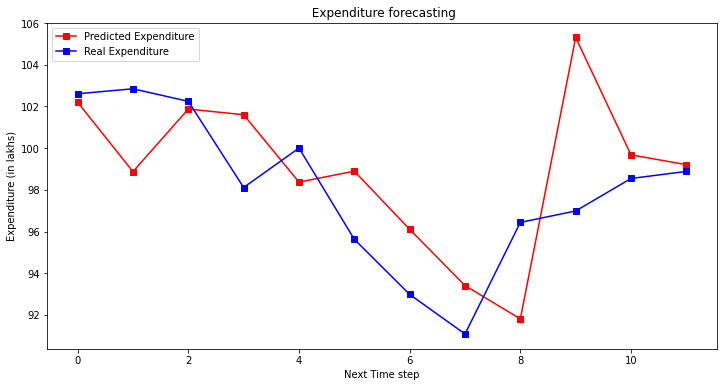

In [ ]:
#plt.xlim([100,500])
plt.figure(figsize=(12, 6))
plt.plot(prediction[0], color = 'red', label = 'Predicted Expenditure',marker="s")
plt.plot(testY[0], color = 'blue', label = 'Real Expenditure',marker="s")
plt.title(' Expenditure forecasting')
plt.xlabel('Next Time step')
plt.ylabel('Expenditure (in lakhs)')
plt.legend()
plt.show()

## Model performance

In [ ]:
from sklearn.metrics import mean_squared_error
#from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
mean_squared_error(prediction, testY)

47.35737746150766